<ipython-input-3-ef06c48531f4>:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


T-statistic: -1.6767726096282591, P-value: 0.09369673920749758


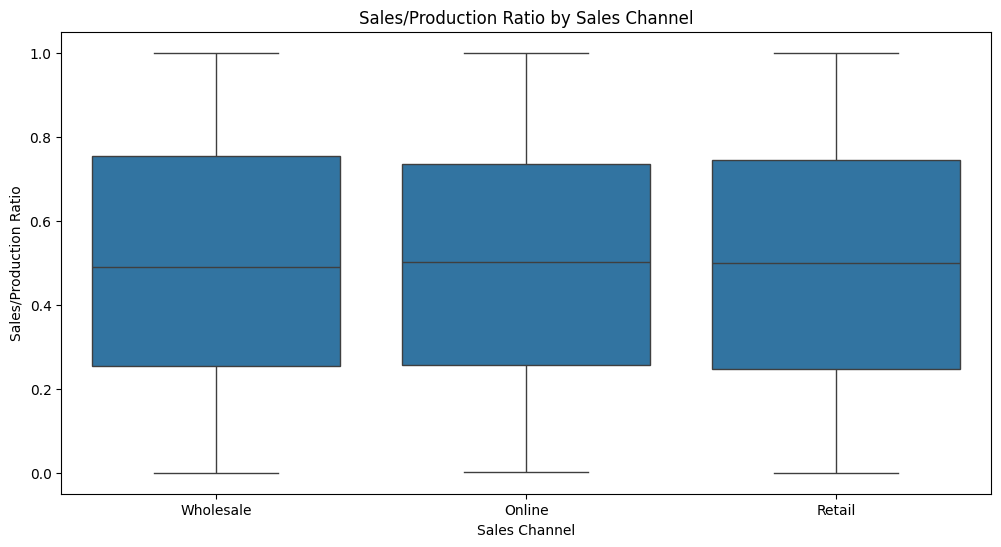

Cross-validation scores: [0.50877193 0.52105263 0.59210526 0.70061457 0.71553995]
Average cross-validation score: 0.6076168692143
              precision    recall  f1-score   support

           0       0.64      0.62      0.63       867
           1       0.62      0.64      0.63       843

    accuracy                           0.63      1710
   macro avg       0.63      0.63      0.63      1710
weighted avg       0.63      0.63      0.63      1710

[[535 332]
 [304 539]]


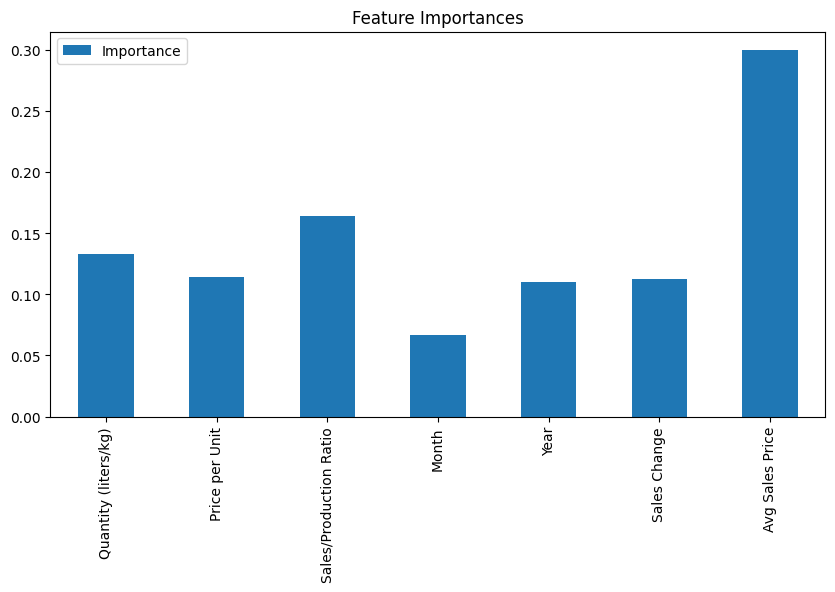

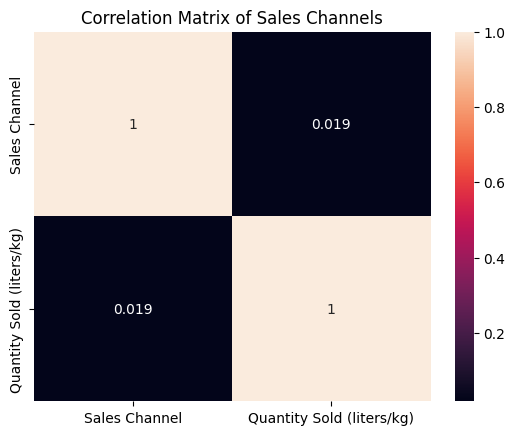

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Load the CSV file
data = pd.read_csv('data.csv')

# Data Cleaning
data['Date'] = pd.to_datetime(data['Date'])
data['Production Date'] = pd.to_datetime(data['Production Date'])
data['Expiration Date'] = pd.to_datetime(data['Expiration Date'])

# Handle missing values if any
data.fillna(method='ffill', inplace=True)

# Feature Engineering
data['Sales/Production Ratio'] = data['Quantity Sold (liters/kg)'] / data['Quantity (liters/kg)']
data['Channel Disruption'] = np.where(data['Sales Channel'].isin(['Online', 'Retail']), 1, 0)

# Additional features
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Sales Change'] = data.groupby(['Year', 'Month'])['Quantity Sold (liters/kg)'].pct_change()
data['Avg Sales Price'] = data.groupby(['Year', 'Month'])['Price per Unit'].transform('mean')

# Fill NaN values created by pct_change
data.fillna(0, inplace=True)

# Separate data by channels
online_data = data[data['Sales Channel'] == 'Online']
retail_data = data[data['Sales Channel'] == 'Retail']

# Statistical Analysis: T-test between online and retail sales
t_stat, p_value = ttest_ind(online_data['Quantity Sold (liters/kg)'], retail_data['Quantity Sold (liters/kg)'])
print(f'T-statistic: {t_stat}, P-value: {p_value}')

# Visualizing the Sales/Production Ratio
plt.figure(figsize=(12, 6))
sns.boxplot(x='Sales Channel', y='Sales/Production Ratio', data=data)
plt.title('Sales/Production Ratio by Sales Channel')
plt.show()

# Preparing data for Machine Learning Model
features = data[['Quantity (liters/kg)', 'Price per Unit', 'Sales/Production Ratio', 'Month', 'Year', 'Sales Change', 'Avg Sales Price']]
target = data['Channel Disruption']

# Handle class imbalance using SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(features, target)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Train a Gradient Boosting model
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Average cross-validation score: {np.mean(cv_scores)}')

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Visualizing the feature importances
importances = pd.DataFrame(model.feature_importances_, index=features.columns, columns=['Importance'])
importances.plot(kind='bar', figsize=(10, 5))
plt.title('Feature Importances')
plt.show()

# Correlation Analysis
corr = data[['Sales Channel', 'Quantity Sold (liters/kg)']].copy()
corr['Sales Channel'] = corr['Sales Channel'].map({'Online': 1, 'Retail': 2, 'Wholesale': 3})
corr_matrix = corr.corr()
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix of Sales Channels')
plt.show()
